In [3]:
import numpy as np
import MC_PHD as mcphd
from matplotlib import pyplot as plt

In [4]:
histo, timeParams = mcphd.MCPHD(uaBulk=0.04, usBulk=10, g=0.9, n=1.4, sdSep=20, slabThickness=60, detRad=3, isRefl=True, maxTime=2.5e-9, nPhotons=5e8, nTimeBins=4096)

[[0, 0, 1, 1], [0.04, 10, 0.9, 1.4]]
nphoton: 5e+08
tstart: 0
tstep: 2.5e-09
tend: 2.5e-09
issrcfrom0: 1


issavedet: 1
Simulation took 11.290955781936646 seconds.


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

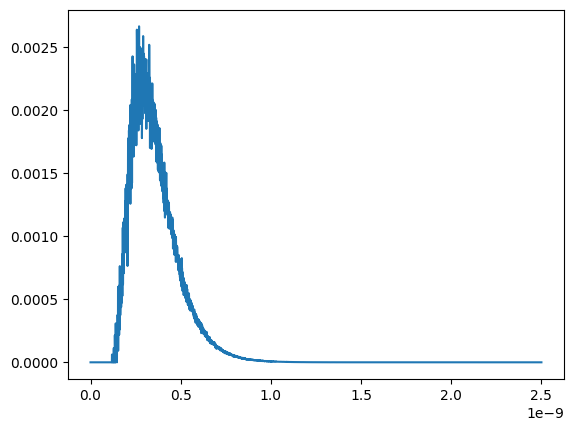

In [5]:
plt.plot(timeParams, histo[0])

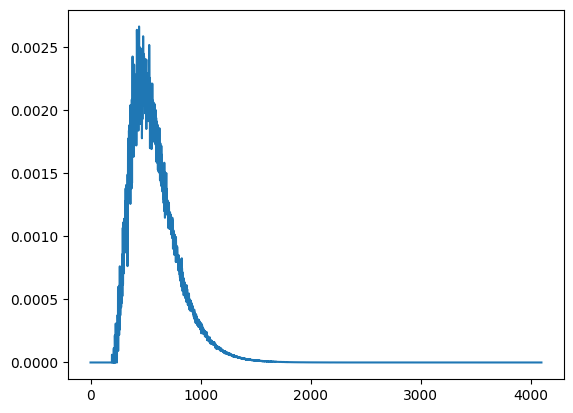

In [6]:
plt.plot(histo[0])